In [1]:
import pandas as pd
import numpy as np
import statsmodels.formula.api as smf

from fmpapi import fmp_get, fmp_set_api_key
from plotnine import *
from mizani.formatters import percent_format, comma_format
from itertools import product

In [19]:
import requests
import pandas as pd

symbol = "PEP"

base = "https://financialmodelingprep.com/stable"

def fetch_df(path, params):
    url = f"{base}/{path}"
    resp = requests.get(url, params=params | {"apikey": api_key})
    if not resp.ok:
        raise RuntimeError(f"{path} error {resp.status_code}: {resp.text[:200]}")
    data = resp.json()
    # Some FMP endpoints return {"data":[...]} or a bare list. Handle both.
    rows = data.get("data", data) if isinstance(data, dict) else data
    return pd.DataFrame(rows)

common = {"symbol": symbol, "period": "annual", "limit": 5}

income_statements = fetch_df("income-statement", common)
balance_sheet     = fetch_df("balance-sheet-statement", common)
cash_flow         = fetch_df("cash-flow-statement", common)

In [21]:
balance_sheet

,date,symbol,reportedCurrency,cik,filingDate,acceptedDate,fiscalYear,period,cashAndCashEquivalents,shortTermInvestments,...,additionalPaidInCapital,accumulatedOtherComprehensiveIncomeLoss,otherTotalStockholdersEquity,totalStockholdersEquity,totalEquity,minorityInterest,totalLiabilitiesAndTotalEquity,totalInvestments,totalDebt,netDebt
0,2024-12-28,PEP,USD,0000077476,2025-02-04,2025-02-03 18:22:47,2024,FY,8505000000,761000000,...,4385000000,-17612000000,0,18041000000,18171000000,130000000,99467000000,4092000000,47751000000,39246000000
1,2023-12-30,PEP,USD,0000077476,2024-02-09,2024-02-08 17:58:51,2023,FY,9711000000,292000000,...,4261000000,-15534000000,0,18503000000,18637000000,134000000,100495000000,4622000000,44661000000,34950000000
2,2022-12-31,PEP,USD,0000077476,2023-02-09,2023-02-08 18:06:37,2022,FY,4954000000,394000000,...,4134000000,-15302000000,0,17149000000,17273000000,124000000,92187000000,4280000000,39554000000,34600000000
3,2021-12-25,PEP,USD,0000077476,2022-02-10,2022-02-09 18:03:39,2021,FY,5596000000,392000000,...,4001000000,-14898000000,0,16043000000,16151000000,108000000,92377000000,3019000000,40780000000,35184000000
4,2020-12-26,PEP,USD,0000077476,2021-02-11,2021-02-10 17:41:49,2020,FY,8185000000,1366000000,...,3910000000,-15476000000,0,13454000000,13552000000,98000000,92918000000,4158000000,44610000000,36425000000


In [25]:
income_statements.columns

Index(['date', 'symbol', 'reportedCurrency', 'cik', 'filingDate',
       'acceptedDate', 'fiscalYear', 'period', 'revenue', 'costOfRevenue',
       'grossProfit', 'researchAndDevelopmentExpenses',
       'generalAndAdministrativeExpenses', 'sellingAndMarketingExpenses',
       'sellingGeneralAndAdministrativeExpenses', 'otherExpenses',
       'operatingExpenses', 'costAndExpenses', 'netInterestIncome',
       'interestIncome', 'interestExpense', 'depreciationAndAmortization',
       'ebitda', 'ebit', 'nonOperatingIncomeExcludingInterest',
       'operatingIncome', 'totalOtherIncomeExpensesNet', 'incomeBeforeTax',
       'incomeTaxExpense', 'netIncomeFromContinuingOperations',
       'netIncomeFromDiscontinuedOperations', 'otherAdjustmentsToNetIncome',
       'netIncome', 'netIncomeDeductions', 'bottomLineNetIncome', 'eps',
       'epsDiluted', 'weightedAverageShsOut', 'weightedAverageShsOutDil'],
      dtype='object')

In [30]:
import pandas as pd

# --- helpers ---
def add_year_from_any(df):
    """Create 'year' from fiscalYear/calendarYear/date-like fields."""
    if df is None or df.empty:
        raise ValueError("DataFrame is empty.")
    c = df.columns
    if "fiscalYear" in c:
        out = df.copy()
        out["year"] = pd.to_numeric(out["fiscalYear"], errors="coerce").astype("Int64")
        return out
    if "calendarYear" in c:
        out = df.copy()
        out["year"] = pd.to_numeric(out["calendarYear"], errors="coerce").astype("Int64")
        return out
    for dcol in ["date","filingDate","acceptedDate","reportDate","fiscalDateEnding","endDate","ended","periodEndDate"]:
        if dcol in c:
            out = df.copy()
            out["year"] = pd.to_datetime(out[dcol], errors="coerce").dt.year.astype("Int64")
            return out
    raise KeyError("No fiscalYear/calendarYear/date-like column to derive 'year'.")

def get_first(df, *names, required=True):
    for n in names:
        if n in df.columns:
            return n
    if required:
        raise KeyError(f"None of {names} found. Available: {list(df.columns)}")
    return None

# --- build left side from income statements ---
inc = add_year_from_any(income_statements)

# prefer existing EBIT; else compute: NI + Tax + InterestExp - InterestInc
col_net_income  = get_first(inc, "netIncome", "net_income")
col_tax         = get_first(inc, "incomeTaxExpense", "income_tax_expense")
col_int_exp     = get_first(inc, "interestExpense", "interest_expense", required=False)
col_int_inc     = get_first(inc, "interestIncome", "interest_income", required=False)
col_revenue     = get_first(inc, "revenue")
col_depr        = get_first(inc, "depreciationAndAmortization", "depreciation_and_amortization", required=False)
has_ebit        = "ebit" in inc.columns

inc_work = inc.copy()
if has_ebit:
    inc_work["ebit_calc"] = pd.to_numeric(inc_work["ebit"], errors="coerce")
else:
    inc_work["ebit_calc"] = (
        pd.to_numeric(inc_work[col_net_income], errors="coerce").fillna(0)
        + pd.to_numeric(inc_work[col_tax], errors="coerce").fillna(0)
        + (pd.to_numeric(inc_work[col_int_exp], errors="coerce").fillna(0) if col_int_exp else 0)
        - (pd.to_numeric(inc_work[col_int_inc], errors="coerce").fillna(0) if col_int_inc else 0)
    )

dcf_left = inc_work.loc[:, ["year", "ebit_calc", col_revenue] + ([col_depr] if col_depr else []) + [col_tax]] \
    .rename(columns={
        "ebit_calc": "ebit",
        col_revenue: "revenue",
        (col_depr or "depr_marker"): "depreciationAndAmortization",
        col_tax: "taxes",
    })

# ensure depreciation column exists
if "depreciationAndAmortization" not in dcf_left.columns:
    dcf_left["depreciationAndAmortization"] = 0.0

# --- cash flow side (handle empty gracefully) ---
if cash_flow_statements is None or cash_flow_statements.empty:
    # fallback: zeros, aligned by income years
    cf_norm = pd.DataFrame({
        "year": dcf_left["year"].astype(int),
        "delta_working_capital": 0.0,
        "capex": 0.0,
    })
else:
    cf_raw = add_year_from_any(cash_flow_statements)
    wc_col = get_first(cf_raw, "changeInWorkingCapital", "change_in_working_capital", required=False)
    capex_col = get_first(cf_raw, "capitalExpenditure", "capitalExpenditures", "capital_expenditure", required=False)

    # try PPE investments if explicit capex not present (usually negative outflow)
    if capex_col is None and "investmentsInPropertyPlantAndEquipment" in cf_raw.columns:
        cf_raw = cf_raw.copy()
        cf_raw["capex"] = -pd.to_numeric(cf_raw["investmentsInPropertyPlantAndEquipment"], errors="coerce").fillna(0.0)
        capex_col = "capex"

    cf_norm = pd.DataFrame({
        "year": cf_raw["year"].astype(int),
        "delta_working_capital": pd.to_numeric(cf_raw[wc_col], errors="coerce").fillna(0.0) if wc_col else 0.0,
        "capex": pd.to_numeric(cf_raw[capex_col], errors="coerce").fillna(0.0) if capex_col else 0.0,
    })

# --- final DCF table ---
dcf_data = (
    dcf_left.merge(cf_norm, on="year", how="left")
            .assign(fcf=lambda x: x["ebit"]
                                  + x["depreciationAndAmortization"]
                                  - x["taxes"]
                                  + x["delta_working_capital"]
                                  - x["capex"])
            .sort_values("year")
            .reset_index(drop=True)
)

print("Income columns:", list(income_statements.columns))
print("Cash-flow empty?" , cash_flow_statements is None or cash_flow_statements.empty)
print(dcf_data.head())


Income columns: ['date', 'symbol', 'reportedCurrency', 'cik', 'filingDate', 'acceptedDate', 'fiscalYear', 'period', 'revenue', 'costOfRevenue', 'grossProfit', 'researchAndDevelopmentExpenses', 'generalAndAdministrativeExpenses', 'sellingAndMarketingExpenses', 'sellingGeneralAndAdministrativeExpenses', 'otherExpenses', 'operatingExpenses', 'costAndExpenses', 'netInterestIncome', 'interestIncome', 'interestExpense', 'depreciationAndAmortization', 'ebitda', 'ebit', 'nonOperatingIncomeExcludingInterest', 'operatingIncome', 'totalOtherIncomeExpensesNet', 'incomeBeforeTax', 'incomeTaxExpense', 'netIncomeFromContinuingOperations', 'netIncomeFromDiscontinuedOperations', 'otherAdjustmentsToNetIncome', 'netIncome', 'netIncomeDeductions', 'bottomLineNetIncome', 'eps', 'epsDiluted', 'weightedAverageShsOut', 'weightedAverageShsOutDil']
Cash-flow empty? True
   year         ebit      revenue  depreciationAndAmortization       taxes  \
0  2020  10197000000  70372000000                   3026000000  1

In [31]:
dcf_data

,year,ebit,revenue,depreciationAndAmortization,taxes,delta_working_capital,capex,fcf
0,2020,10197000000,70372000000,3026000000,1894000000,0.0,0.0,1.132900e+10
1,2021,11684000000,79474000000,3215000000,2142000000,0.0,0.0,1.275700e+10
2,2022,11644000000,86392000000,3280000000,1727000000,0.0,0.0,1.319700e+10
3,2023,12236000000,91471000000,3518000000,2262000000,0.0,0.0,1.349200e+10
4,2024,12865000000,91854000000,3815000000,2320000000,0.0,0.0,1.436000e+10


In [33]:
dcf_data["fcf"][0]

np.float64(11329000000.0)

In [35]:
import pandas as pd

def first_col(df, *cands, required=True):
    for c in cands:
        if c in df.columns:
            return c
    if required:
        raise KeyError(f"None of {cands} found. Available: {list(df.columns)}")
    return None

def add_year(df):
    if df is None or df.empty:
        return pd.DataFrame(columns=["year"])
    if "fiscalYear" in df.columns:
        return df.assign(year=pd.to_numeric(df["fiscalYear"], errors="coerce").astype("Int64"))
    if "calendarYear" in df.columns:
        return df.assign(year=pd.to_numeric(df["calendarYear"], errors="coerce").astype("Int64"))
    if "calendar_year" in df.columns:
        return df.assign(year=pd.to_numeric(df["calendar_year"], errors="coerce").astype("Int64"))
    if "date" in df.columns:
        return df.assign(year=pd.to_datetime(df["date"], errors="coerce").dt.year.astype("Int64"))
    # fallback: leave empty
    return df.assign(year=pd.Series(dtype="Int64"))

# ---- Income side ----
inc = add_year(income_statements).copy()

# pick columns (camelCase first, then snake_case)
col_net_income = first_col(inc, "netIncome", "net_income")
col_tax        = first_col(inc, "incomeTaxExpense", "income_tax_expense")
col_int_exp    = first_col(inc, "interestExpense", "interest_expense", required=False)
col_int_inc    = first_col(inc, "interestIncome", "interest_income", required=False)
col_rev        = first_col(inc, "revenue")
col_depr       = first_col(inc, "depreciationAndAmortization", "depreciation_and_amortization", required=False)

# EBIT (use existing 'ebit' if present, else compute)
if "ebit" in inc.columns:
    inc["ebit_calc"] = pd.to_numeric(inc["ebit"], errors="coerce")
else:
    inc["ebit_calc"] = (
        pd.to_numeric(inc[col_net_income], errors="coerce").fillna(0.0)
        + pd.to_numeric(inc[col_tax], errors="coerce").fillna(0.0)
        + (pd.to_numeric(inc[col_int_exp], errors="coerce").fillna(0.0) if col_int_exp else 0.0)
        - (pd.to_numeric(inc[col_int_inc], errors="coerce").fillna(0.0) if col_int_inc else 0.0)
    )

dcf_left = (
    inc.rename(columns={col_tax: "taxes", col_rev: "revenue"})
       .assign(depr=lambda x: pd.to_numeric(x[col_depr], errors="coerce") if col_depr else 0.0)
       .loc[:, ["year", "ebit_calc", "revenue", "depr", "taxes"]]
       .rename(columns={"ebit_calc": "ebit", "depr": "depreciationAndAmortization"})
)

# ---- Cash-flow side ----
if cash_flow_statements is None or cash_flow_statements.empty:
    cf_norm = pd.DataFrame({
        "year": dcf_left["year"].astype("Int64"),
        "delta_working_capital": 0.0,
        "capex": 0.0,
    })
else:
    cf = add_year(cash_flow_statements).copy()

    # ΔWC
    wc_col = first_col(cf, "changeInWorkingCapital", "change_in_working_capital", required=False)
    if wc_col:
        cf["delta_working_capital"] = pd.to_numeric(cf[wc_col], errors="coerce").fillna(0.0)
    else:
        cf["delta_working_capital"] = 0.0

    # Capex (several possible names)
    if "capitalExpenditure" in cf.columns:
        capex_series = cf["capitalExpenditure"]
    elif "capitalExpenditures" in cf.columns:
        capex_series = cf["capitalExpenditures"]
    elif "capital_expenditure" in cf.columns:
        capex_series = cf["capital_expenditure"]
    elif "investmentsInPropertyPlantAndEquipment" in cf.columns:
        # Usually a negative cash outflow; convert to positive capex
        capex_series = -pd.to_numeric(cf["investmentsInPropertyPlantAndEquipment"], errors="coerce")
    else:
        capex_series = 0.0
    cf["capex"] = pd.to_numeric(capex_series, errors="coerce").fillna(0.0)

    cf_norm = cf.loc[:, ["year", "delta_working_capital", "capex"]]

# ---- Final DCF table ----
dcf_data = (
    dcf_left.merge(cf_norm, on="year", how="left")
            .assign(
                delta_working_capital=lambda x: x["delta_working_capital"].fillna(0.0),
                capex=lambda x: x["capex"].fillna(0.0),
                depreciationAndAmortization=lambda x: x["depreciationAndAmortization"].fillna(0.0),
                taxes=lambda x: x["taxes"].fillna(0.0),
                fcf=lambda x: x["ebit"] + x["depreciationAndAmortization"] - x["taxes"]
                              + x["delta_working_capital"] - x["capex"]
            )
            .sort_values("year")
            .reset_index(drop=True)
)

print(dcf_data.head())


   year         ebit      revenue  depreciationAndAmortization       taxes  \
0  2020  10197000000  70372000000                   3026000000  1894000000   
1  2021  11684000000  79474000000                   3215000000  2142000000   
2  2022  11644000000  86392000000                   3280000000  1727000000   
3  2023  12236000000  91471000000                   3518000000  2262000000   
4  2024  12865000000  91854000000                   3815000000  2320000000   

   delta_working_capital  capex           fcf  
0                    0.0    0.0  1.132900e+10  
1                    0.0    0.0  1.275700e+10  
2                    0.0    0.0  1.319700e+10  
3                    0.0    0.0  1.349200e+10  
4                    0.0    0.0  1.436000e+10  


In [36]:
dcf_data

,year,ebit,revenue,depreciationAndAmortization,taxes,delta_working_capital,capex,fcf
0,2020,10197000000,70372000000,3026000000,1894000000,0.0,0.0,1.132900e+10
1,2021,11684000000,79474000000,3215000000,2142000000,0.0,0.0,1.275700e+10
2,2022,11644000000,86392000000,3280000000,1727000000,0.0,0.0,1.319700e+10
3,2023,12236000000,91471000000,3518000000,2262000000,0.0,0.0,1.349200e+10
4,2024,12865000000,91854000000,3815000000,2320000000,0.0,0.0,1.436000e+10


/opt/anaconda3/envs/QF-Playground/lib/python3.12/site-packages/mizani/palettes.py:557: UserWarning: Warning message:Brewer palette Dark2 has a maximum of 8 colors Returning the palette you asked for with that many colors
/opt/anaconda3/envs/QF-Playground/lib/python3.12/site-packages/plotnine/layer.py:372: PlotnineWarning: geom_point : Removed 1 rows containing missing values.


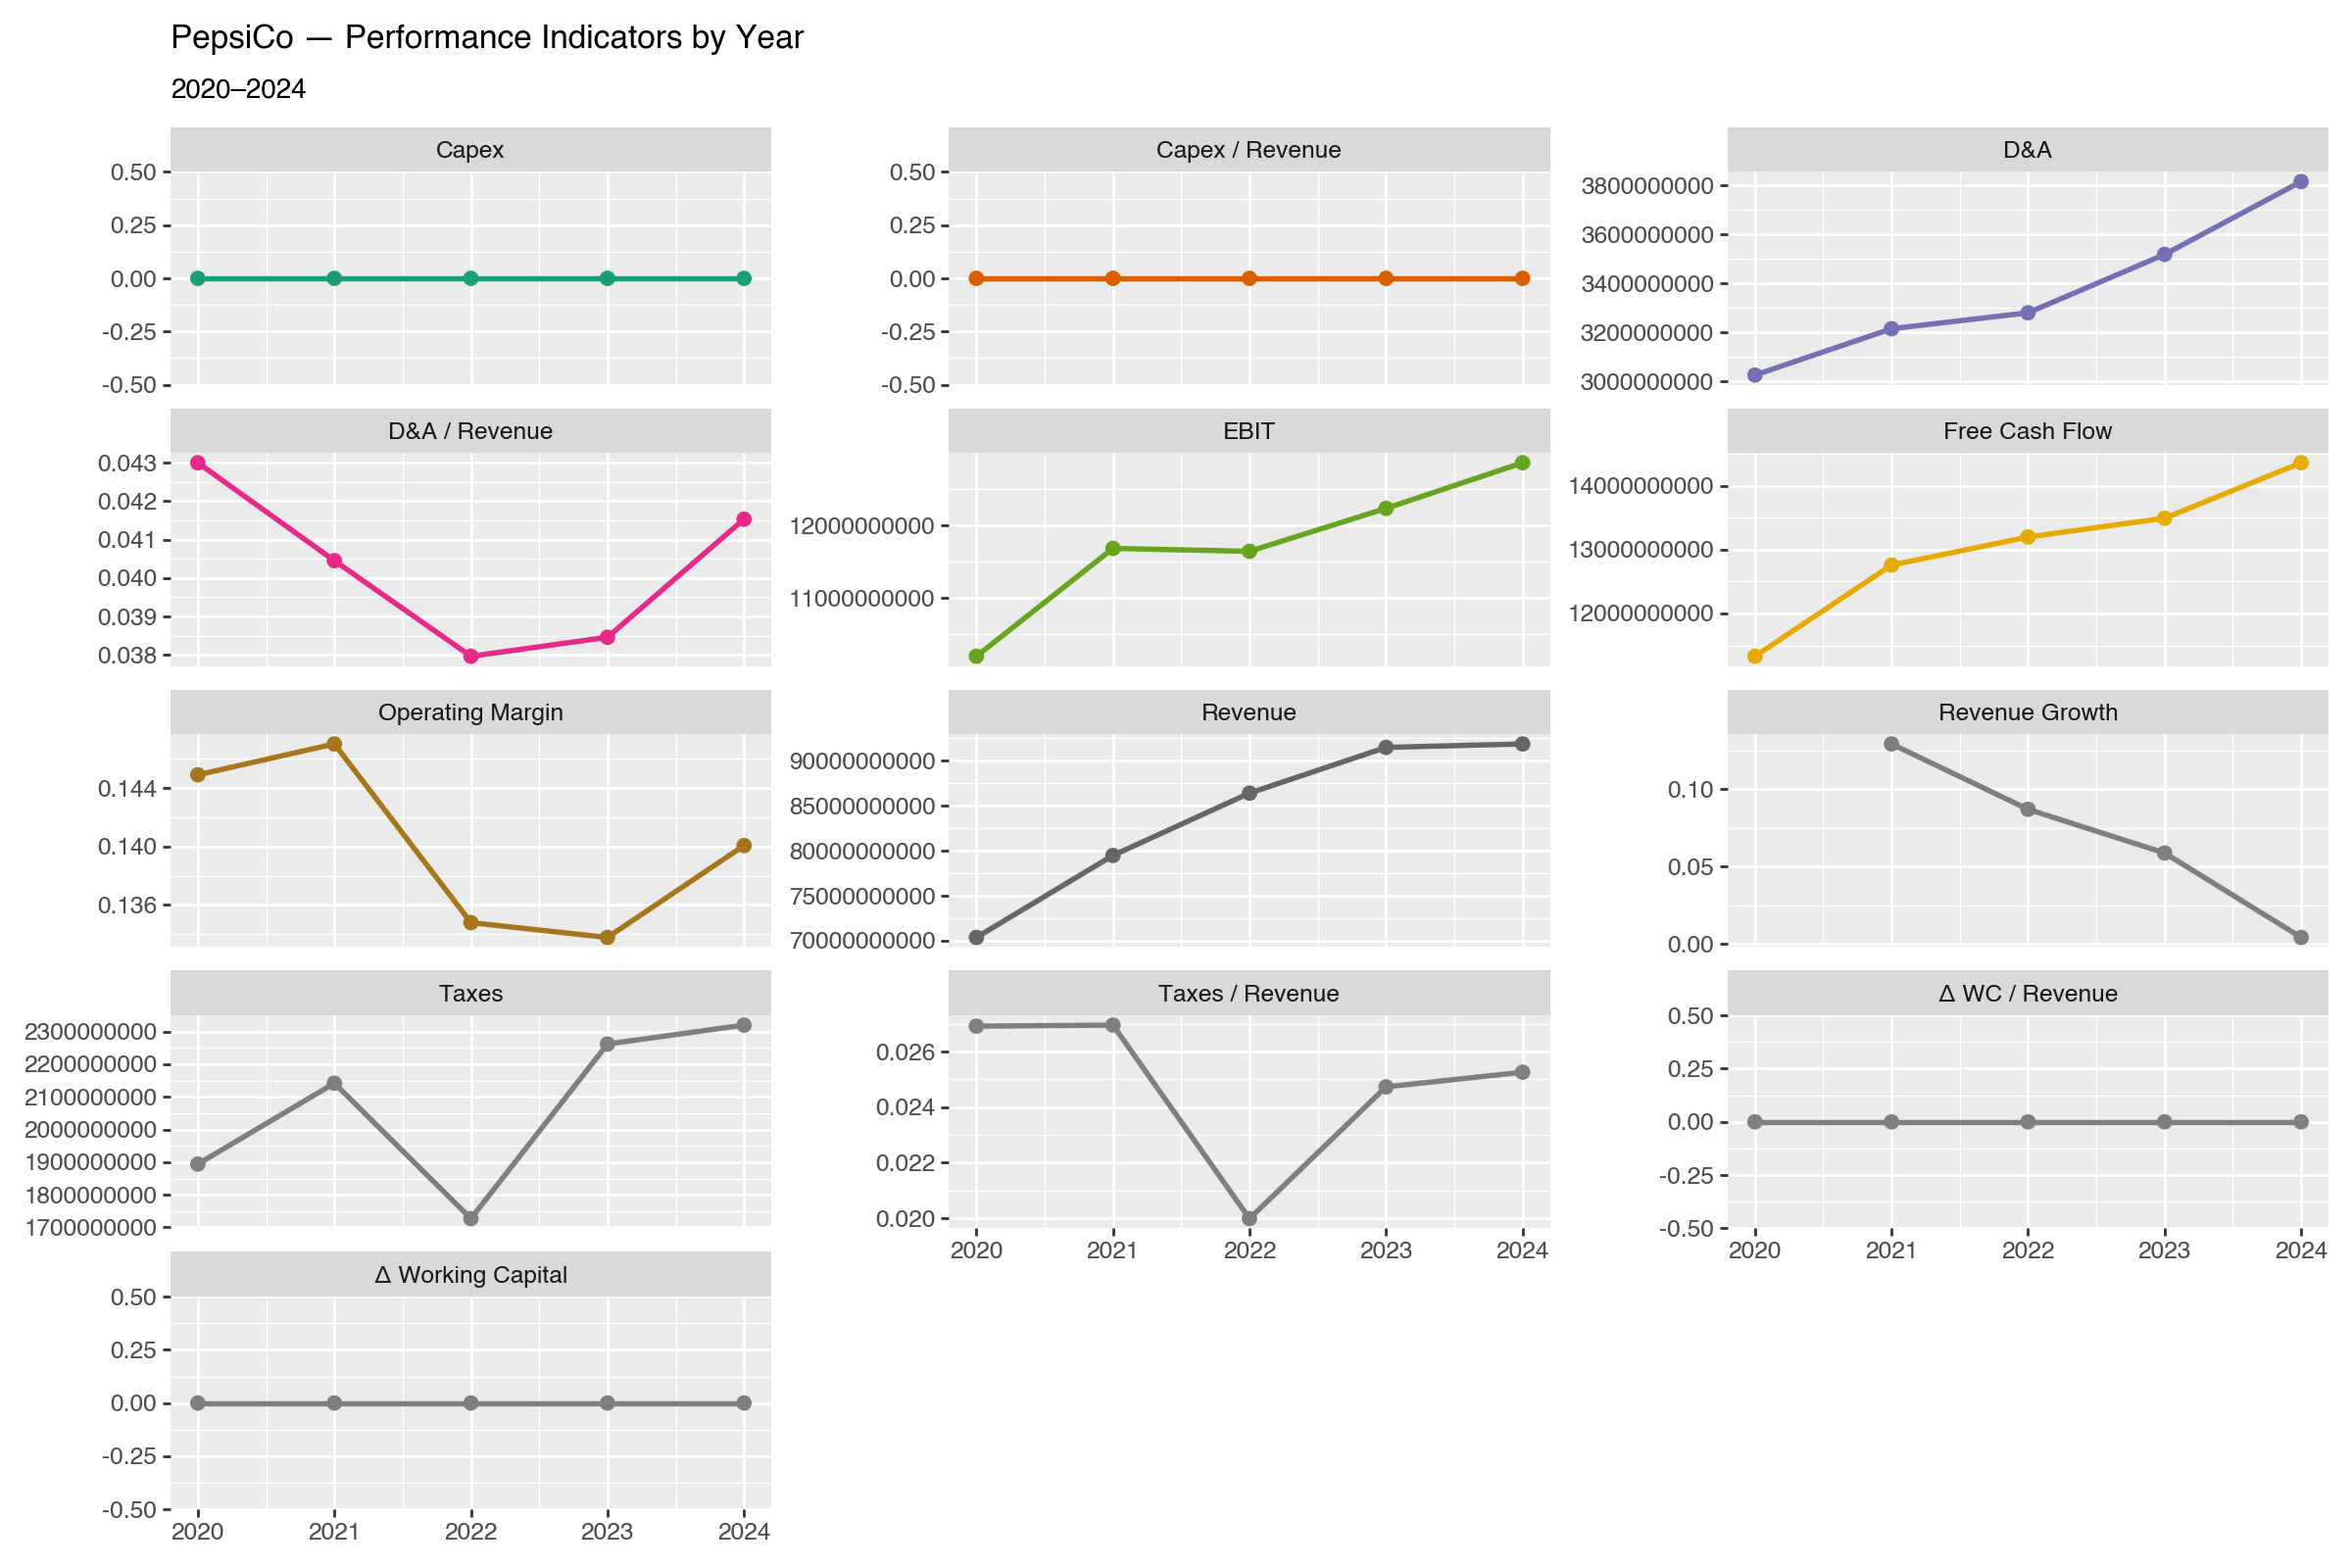

In [41]:
import numpy as np
from plotnine import (
    ggplot, aes, geom_line, geom_point, facet_wrap, labs, scale_y_continuous,
    scale_color_brewer, theme, element_text
)
from mizani.formatters import percent_format

# Pretty names for facet labels
nice_names = {
    "revenue": "Revenue",
    "ebit": "EBIT",
    "depreciationAndAmortization": "D&A",
    "taxes": "Taxes",
    "delta_working_capital": "Δ Working Capital",
    "capex": "Capex",
    "fcf": "Free Cash Flow",
    "revenue_growth": "Revenue Growth",
    "operating_margin": "Operating Margin",
    "da_margin": "D&A / Revenue",
    "taxes_to_revenue": "Taxes / Revenue",
    "delta_working_capital_to_revenue": "Δ WC / Revenue",
    "capex_to_revenue": "Capex / Revenue",
}

# make a readable copy
perf_plot = performance_long.copy()
perf_plot["indicator"] = perf_plot["indicator"].map(lambda s: nice_names.get(s, s))

# separate ratio vs absolute for proper y formatting
ratio_names = {
    "Revenue Growth", "Operating Margin", "D&A / Revenue", "Taxes / Revenue",
    "Δ WC / Revenue", "Capex / Revenue"
}

def pct_if_ratio(breaks, i):
    # percent axis only for ratio facets
    # plotnine calls the formatter with (breaks, tick_index)
    return [f"{b*100:.0f}%" for b in breaks]

plot_facets = (
    ggplot(perf_plot, aes("year", "value", color="indicator", group="indicator"))
    + geom_line(size=1.1)
    + geom_point(size=2.2)
    + facet_wrap("~indicator", scales="free_y", ncol=3)
    + scale_color_brewer(type="qualitative", palette="Dark2")
    + scale_y_continuous()  # (kept generic; each panel has free_y)
    + labs(
        title=f"PepsiCo — Performance Indicators by Year",
        subtitle=f"{int(dcf_data['year'].min())}–{int(dcf_data['year'].max())}",
        x="", y="", color=""
    )
    + theme(
        figure_size=(12, 8),
        axis_text_x=element_text(rotation=0, ha="center"),
        legend_position="none",
        plot_title=element_text(weight="bold", size=12),
        plot_subtitle=element_text(size=10)
    )
)
plot_facets.show()


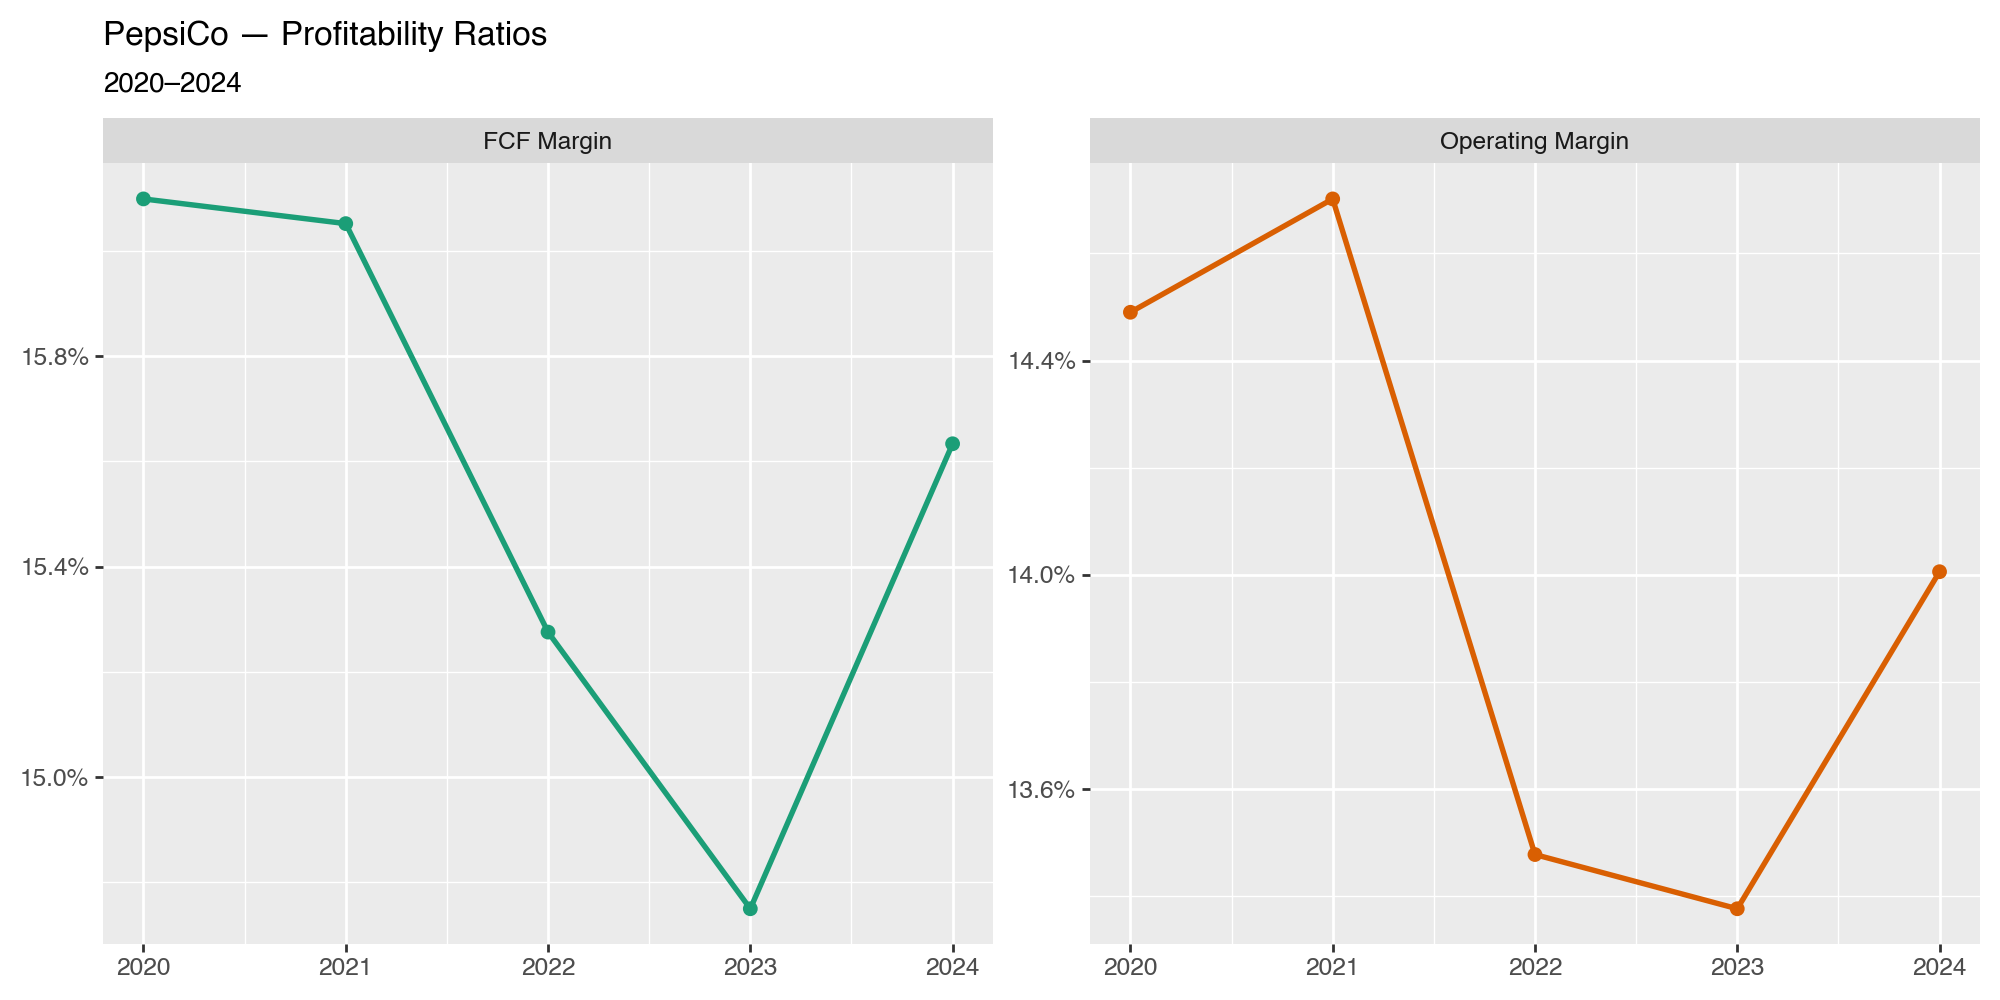

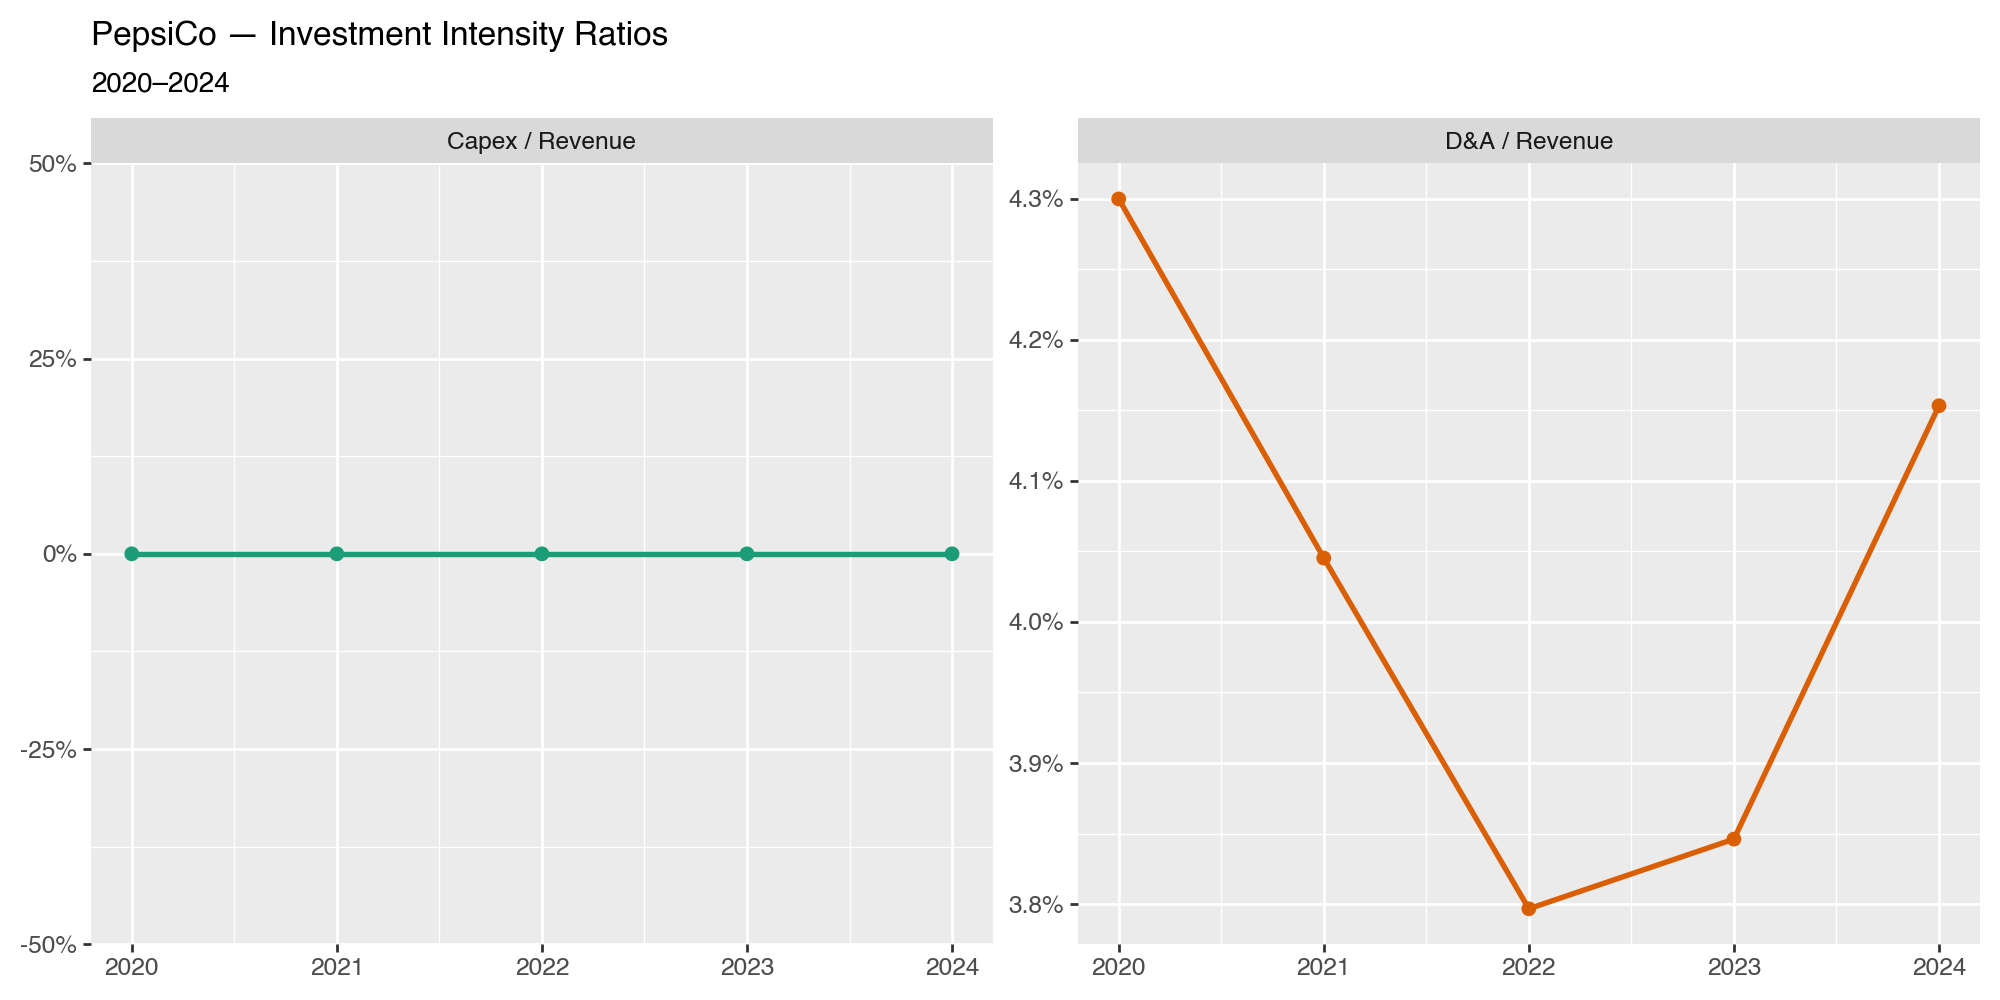

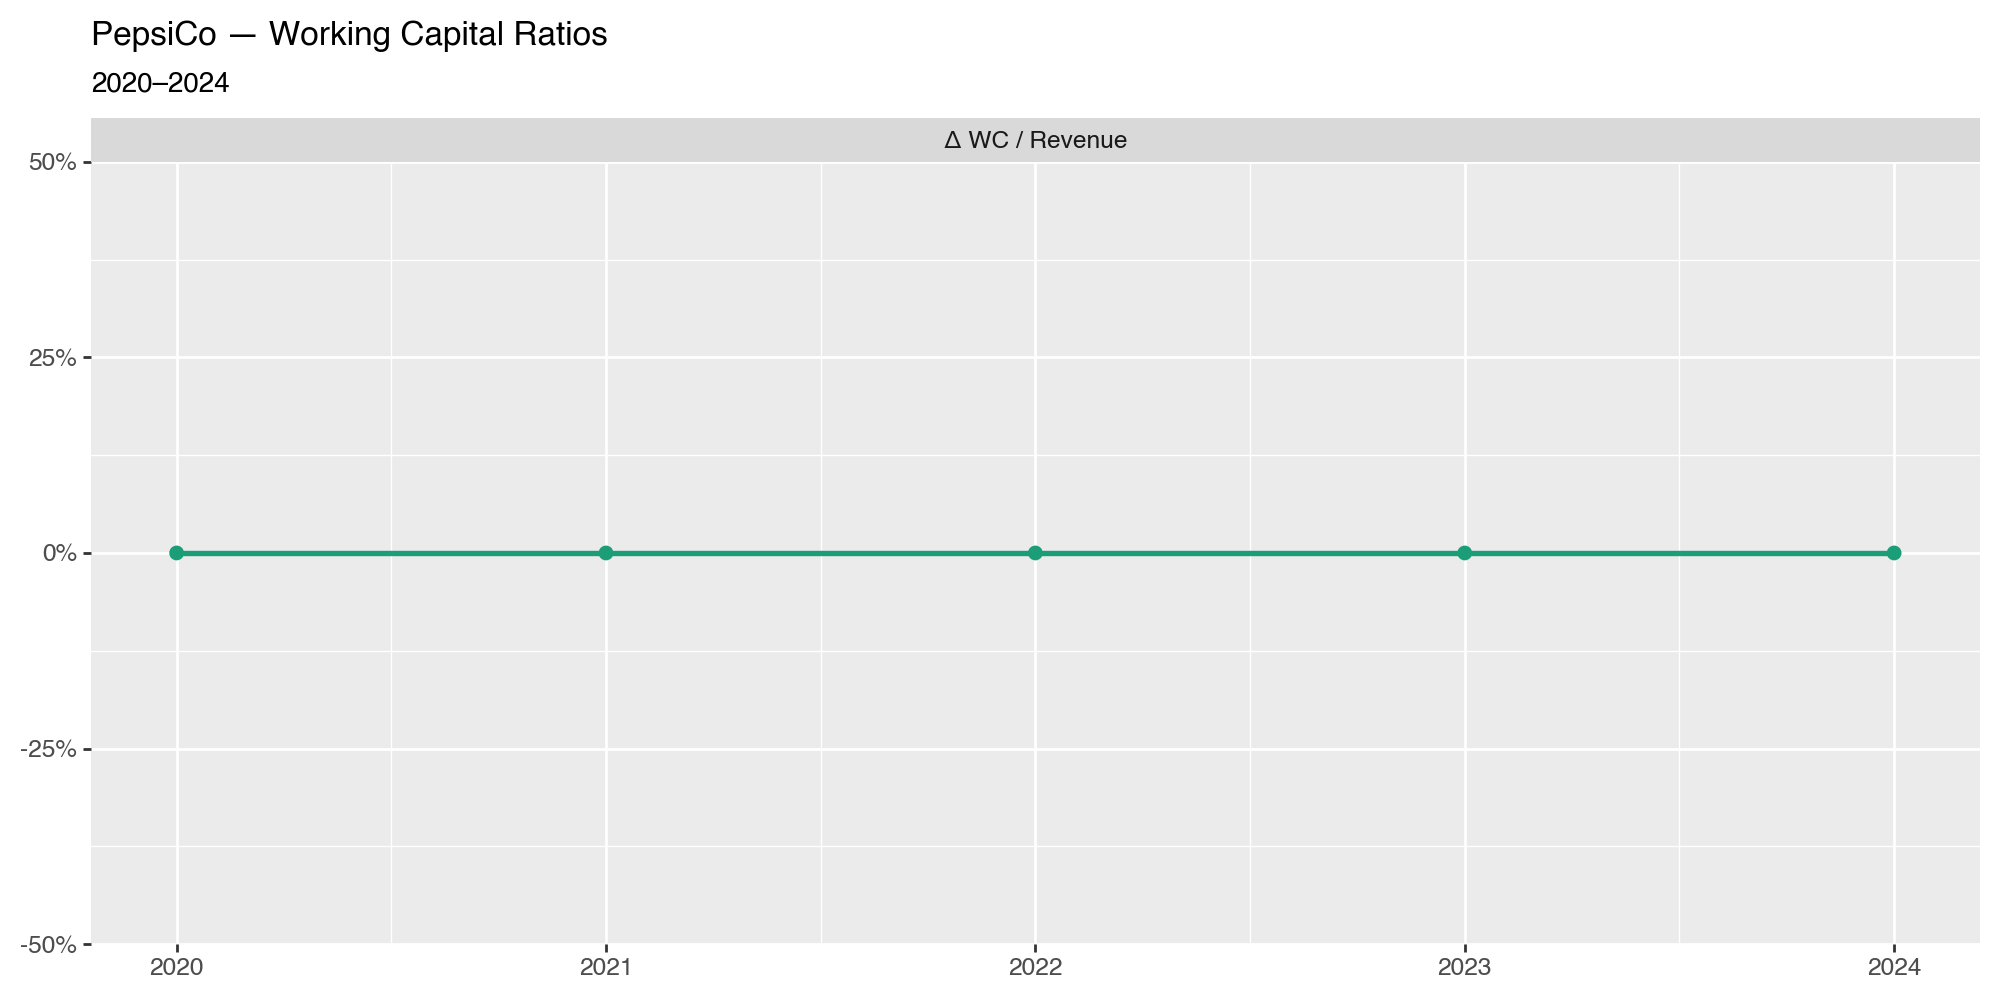

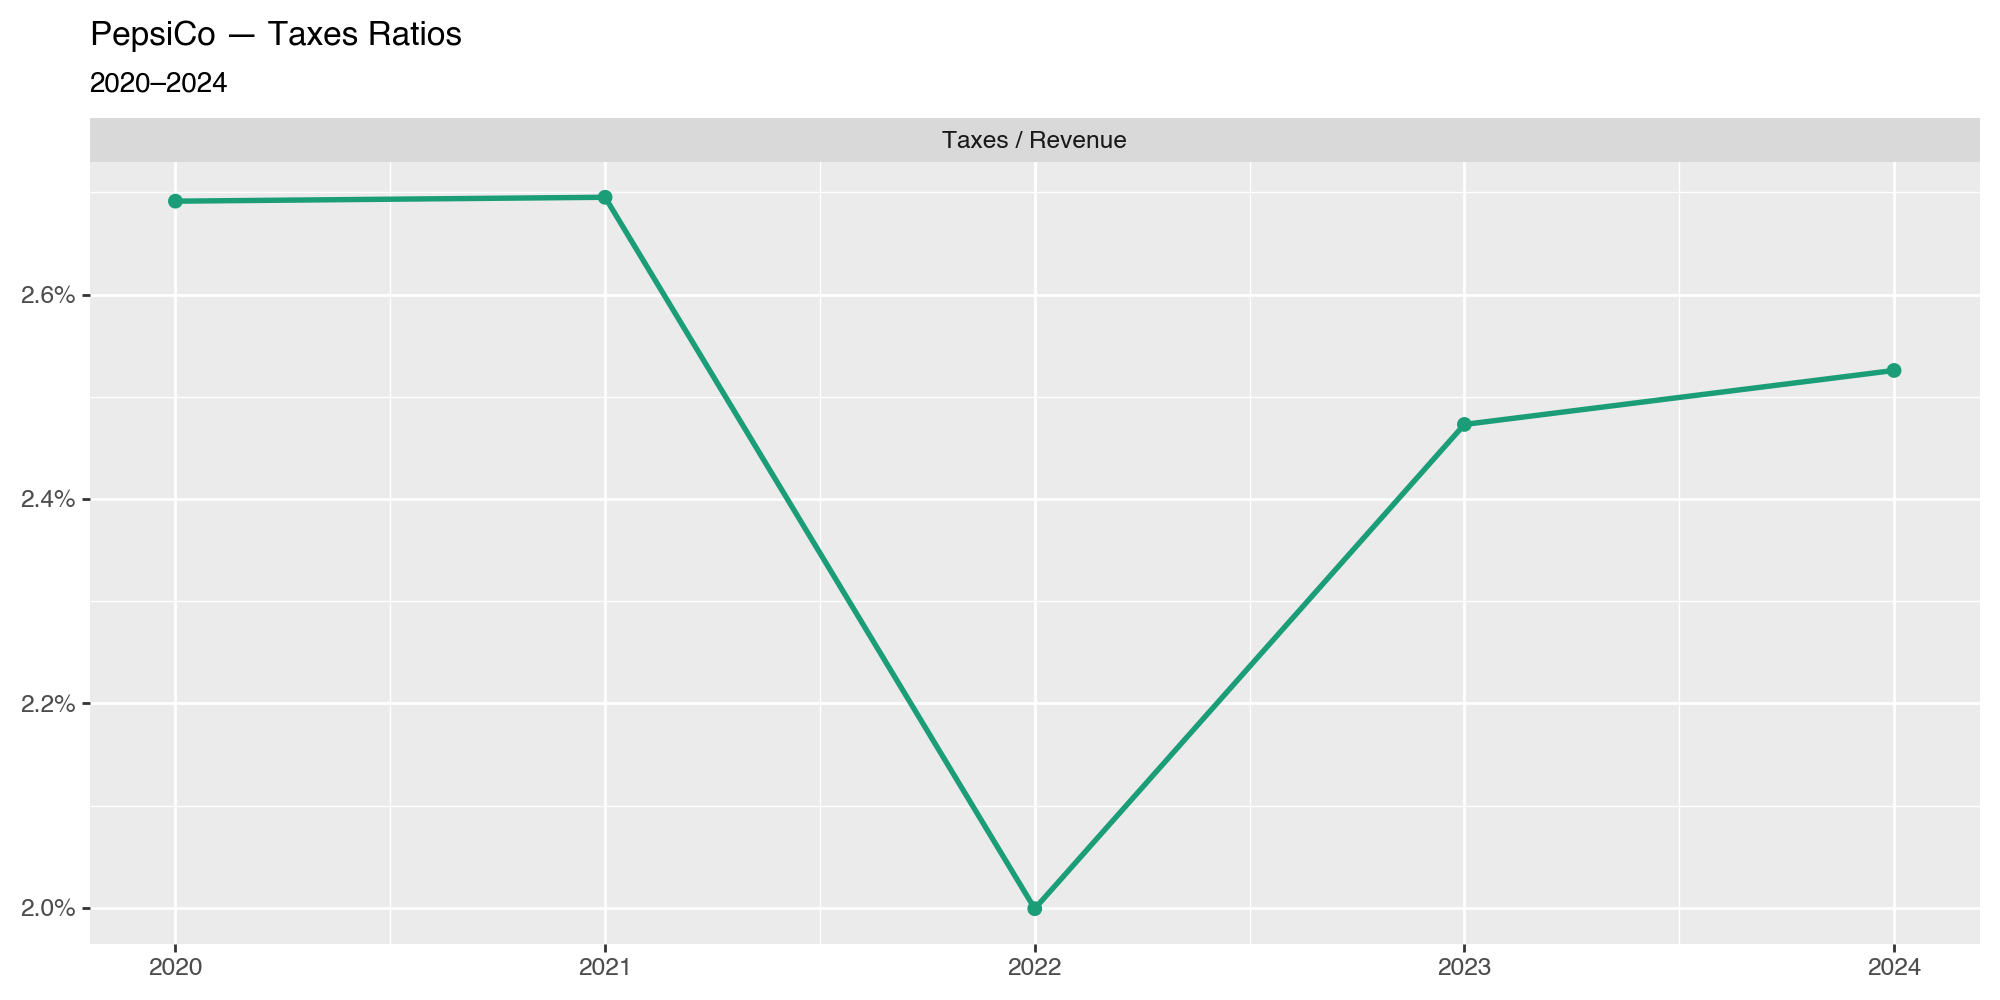

/opt/anaconda3/envs/QF-Playground/lib/python3.12/site-packages/plotnine/geoms/geom_path.py:100: PlotnineWarning: geom_path: Removed 1 rows containing missing values.
/opt/anaconda3/envs/QF-Playground/lib/python3.12/site-packages/plotnine/layer.py:372: PlotnineWarning: geom_point : Removed 1 rows containing missing values.


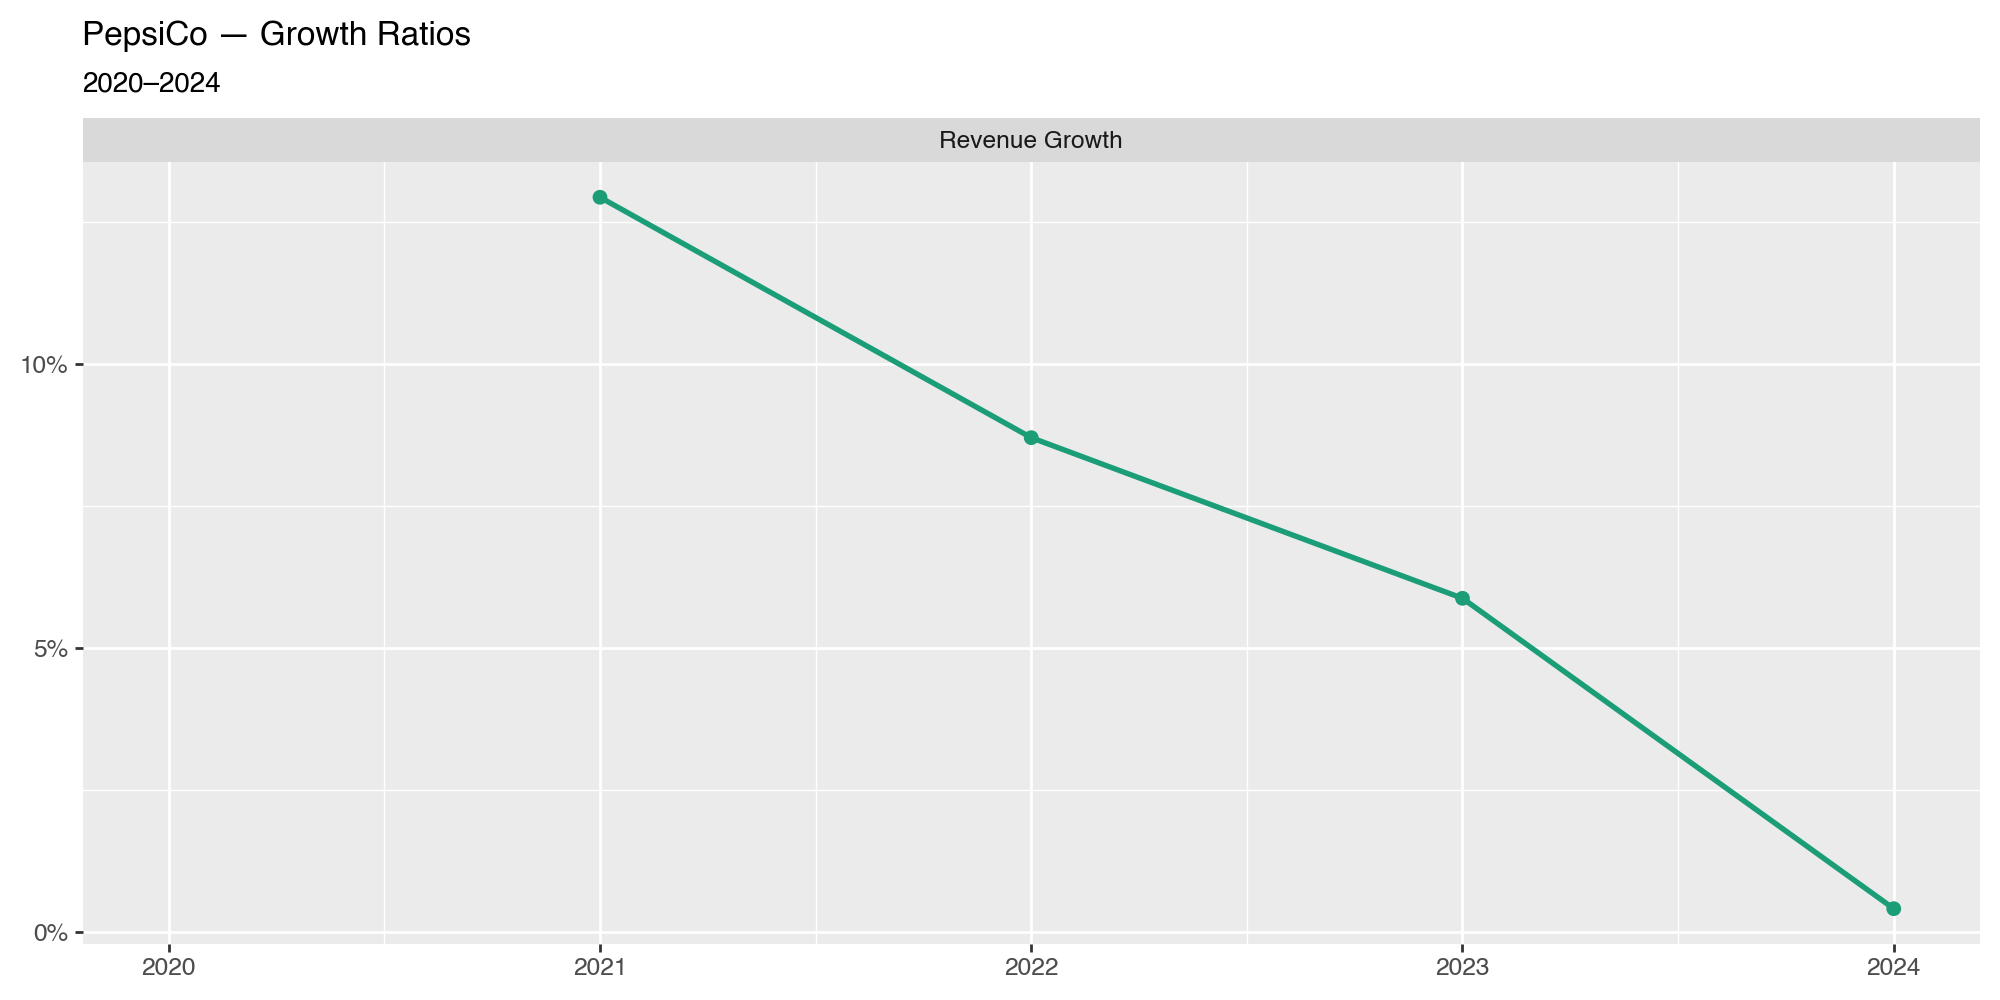

In [42]:
import numpy as np
from plotnine import (
    ggplot, aes, geom_line, geom_point, facet_wrap, labs,
    scale_y_continuous, scale_color_brewer, theme, element_text
)
from mizani.formatters import percent_format

# 1) Ensure all ratios exist (add FCF margin)
dcf_data = (
    dcf_data
    .assign(
        revenue_growth=lambda df: df["revenue"].pct_change(),
        operating_margin=lambda df: np.where(df["revenue"] != 0, df["ebit"] / df["revenue"], np.nan),
        fcf_margin=lambda df: np.where(df["revenue"] != 0, df["fcf"] / df["revenue"], np.nan),
        da_margin=lambda df: np.where(df["revenue"] != 0, df["depreciationAndAmortization"] / df["revenue"], np.nan),
        taxes_to_revenue=lambda df: np.where(df["revenue"] != 0, df["taxes"] / df["revenue"], np.nan),
        delta_working_capital_to_revenue=lambda df: np.where(df["revenue"] != 0, df["delta_working_capital"] / df["revenue"], np.nan),
        capex_to_revenue=lambda df: np.where(df["revenue"] != 0, df["capex"] / df["revenue"], np.nan),
    )
    .replace([np.inf, -np.inf], np.nan)
)

# 2) Define classes of ratios
ratio_classes = {
    "Profitability": [
        "operating_margin",   # EBIT / Revenue
        "fcf_margin",         # FCF / Revenue
    ],
    "Investment Intensity": [
        "capex_to_revenue",   # Capex / Revenue
        "da_margin",          # D&A / Revenue
    ],
    "Working Capital": [
        "delta_working_capital_to_revenue",  # ΔWC / Revenue
    ],
    "Taxes": [
        "taxes_to_revenue",   # Taxes / Revenue
    ],
    "Growth": [
        "revenue_growth",     # Revenue growth YoY
    ],
}

# Pretty names
pretty = {
    "operating_margin": "Operating Margin",
    "fcf_margin": "FCF Margin",
    "capex_to_revenue": "Capex / Revenue",
    "da_margin": "D&A / Revenue",
    "delta_working_capital_to_revenue": "Δ WC / Revenue",
    "taxes_to_revenue": "Taxes / Revenue",
    "revenue_growth": "Revenue Growth",
}

# 3) Make a long frame of all ratios we care about
all_ratio_names = [n for group in ratio_classes.values() for n in group]
ratios_long = (
    dcf_data[["year"] + all_ratio_names]
      .melt(id_vars="year", var_name="indicator", value_name="value")
      .assign(indicator=lambda df: df["indicator"].map(lambda s: pretty.get(s, s)))
)

# helper to plot one class
def plot_ratio_class(class_name, ncol=2):
    subset = ratio_classes[class_name]
    use_names = [pretty.get(n, n) for n in subset]
    df = ratios_long[ratios_long["indicator"].isin(use_names)].copy()
    return (
        ggplot(df, aes("year", "value", color="indicator", group="indicator"))
        + geom_line(size=1.1)
        + geom_point(size=2.0)
        + facet_wrap("~indicator", scales="free_y", ncol=ncol)
        + scale_y_continuous(labels=percent_format())
        + scale_color_brewer(type="qualitative", palette="Dark2")
        + labs(
            title=f"PepsiCo — {class_name} Ratios",
            subtitle=f"{int(dcf_data['year'].min())}–{int(dcf_data['year'].max())}",
            x="", y="", color=""
        )
        + theme(
            figure_size=(10, 5),
            axis_text_x=element_text(rotation=0, ha="center"),
            legend_position="none",
            plot_title=element_text(weight="bold", size=12),
            plot_subtitle=element_text(size=10),
        )
    )

# 4) Build plots per class (show the ones you want)
plot_profitability = plot_ratio_class("Profitability", ncol=2)
plot_investment    = plot_ratio_class("Investment Intensity", ncol=2)
plot_working_cap   = plot_ratio_class("Working Capital", ncol=1)
plot_taxes         = plot_ratio_class("Taxes", ncol=1)
plot_growth        = plot_ratio_class("Growth", ncol=1)

# Display
plot_profitability.show()
plot_investment.show()
plot_working_cap.show()
plot_taxes.show()
plot_growth.show()
